In [1]:
import sys
import torch
import geoopt

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from geoopt import linalg
from geoopt.optim import RiemannianSGD, RiemannianAdam
from copy import deepcopy

sys.path.append("./lib/data")
from get_data import get_data, get_cov

sys.path.append("./lib/spdnet")
import nn as nn_spd
# from optimizers import MixOptimizer

# sys.path.append("./lib")
# from swspd import sliced_wasserstein_spd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [3]:
seed = 2023

# random.seed(args.seed)
# np.random.seed(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.benchmark=True

### Data

In [4]:
subject = 1
Xs, ys = get_data(subject, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(subject, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [5]:
print(Xs.shape, cov_Xs.shape, Xt.shape, cov_Xt.shape)

(273, 22, 1750) torch.Size([273, 1, 1, 22, 22]) (281, 22, 1750) torch.Size([281, 1, 1, 22, 22])


In [6]:
d = 22
n_classes = 4

freq = 0

In [7]:
def plot_tsne(Xs, Xt, suptitle=None):
    log_Xs = linalg.sym_logm(Xs.detach().cpu()).reshape(-1, d*d)
    log_Xt = linalg.sym_logm(Xt.detach().cpu()).reshape(-1, d*d)

    log_data = torch.cat([log_Xs, log_Xt], dim=0)

    X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(log_data.numpy())


    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
    ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

    ax[0].legend()
    ax[1].legend()
    
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


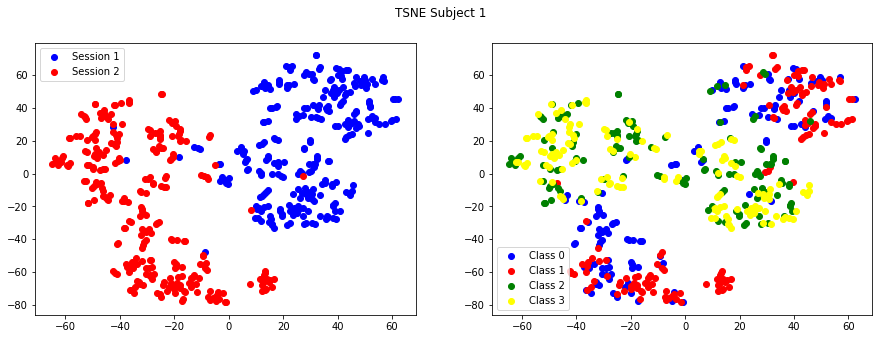

In [8]:
plot_tsne(cov_Xs[:,:,freq], cov_Xt[:,:,freq], suptitle="TSNE Subject 1")

### Neural Net

In [9]:
class mlp_spd(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        self.dense1 = nn.Linear(d_in, 10)
        self.dense2 = nn.Linear(10, d_out)
        self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices


    def forward(self, x_spd):
        x = self.logeig(x_spd).view(x_spd.shape[0], -1)
        
        ## Amélioration possible: Upper vect of log instead of just log

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
            
        return F.softmax(x, dim=-1)
    

In [10]:
def init_all(model, init_func, *params, **kwargs):
    for p in model.parameters():
        init_func(p, *params, **kwargs)
        
        
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
        
        
def weights_init_uniform(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('Linear') != -1:
            # apply a uniform distribution to the weights and a bias=0
            m.weight.data.uniform_(0.0, 1.0)
            m.bias.data.fill_(0)

### Training

#### Training on Target

In [11]:
seed = 2023

# random.seed(args.seed)
# np.random.seed(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.benchmark=True


epochs = 1000
# num_projs = 500

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, n_classes).to(device)
# init_all(classifier, torch.nn.init.normal_, mean=0., std=1) 
# classifier.apply(weights_init_uniform)
# classifier.apply(init_weights)
# init_all(classifier, torch.nn.init.constant_, 0.) 

print("Number of parameters:", str(sum(p.numel() for p in classifier.parameters())))

# optimizer = MixOptimizer(list(classifier.parameters()), lr=lr)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2) #, momentum=0.9, weight_decay=5e-4)

L_loss = []
L_acc = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xt[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, yt)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f}")



Number of parameters: 4894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.27it/s, loss = 0.756 acc = 99.644]


In [12]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 99.64412689208984%


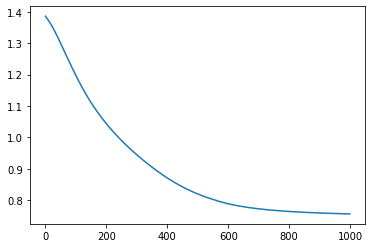

In [13]:
plt.plot(L_loss)
plt.show()

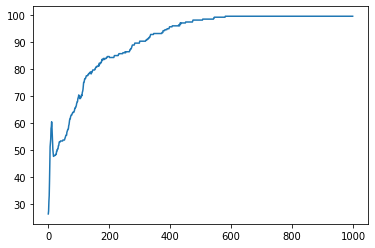

In [14]:
plt.plot(L_acc)
plt.show()

#### Training on Source

In [15]:
seed = 2023

# random.seed(args.seed)
# np.random.seed(args.seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.benchmark=True


epochs = 1000
# num_projs = 500
d = 22
n_classes = 4

freq = 0

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, n_classes).to(device)
# init_all(classifier, torch.nn.init.normal_, mean=0., std=1) 
# classifier.apply(weights_init_uniform)
# classifier.apply(init_weights)
# init_all(classifier, torch.nn.init.constant_, 0.) 

print("Number of parameters:", str(sum(p.numel() for p in classifier.parameters())))

# optimizer = MixOptimizer(list(classifier.parameters()), lr=lr)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2) #, momentum=0.9, weight_decay=5e-4)

L_loss = []
L_acc = []
L_acc_test = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xs[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, ys)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        y_test = classifier(cov_Xs[:,:,freq].type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == ys) * 100/len(ys)
        L_acc.append(acc.item())
        
        
        y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
        acc_test = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        L_acc_test.append(acc_test.item())
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f} " + f"acc_test = {acc_test.item():.3f}")



Number of parameters: 4894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.39it/s, loss = 0.756 acc = 99.634 acc_test = 71.530]


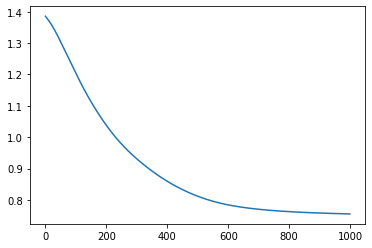

In [16]:
plt.plot(L_loss)
plt.show()

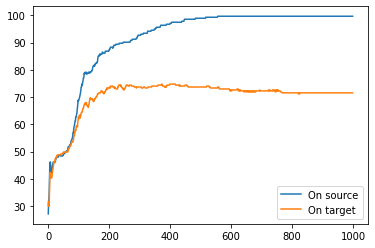

In [17]:
plt.plot(L_acc, label="On source")
plt.plot(L_acc_test, label="On target")
plt.legend()
plt.show()